# FABEMD

In [24]:
import numpy as np
import logging
from scipy.ndimage import maximum_filter, minimum_filter, uniform_filter

# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


def get_local_extrema(image, window_size=3):
    """Get local maxima and minima maps for a given image."""
    # logging.info(f"Finding local extrema with window size: {window_size}")
    max_map = image == maximum_filter(image, size=window_size)
    min_map = image == minimum_filter(image, size=window_size)
    return max_map, min_map


def apply_order_statistic_filter(image, extrema_map, filter_type="max", window_size=3):
    """Approximate the envelope using order statistics filters (MAX/MIN)"""
    # logging.info(f"Applying {filter_type} filter with window size: {window_size}")
    if filter_type == "max":
        envelope = maximum_filter(image, size=window_size)
    elif filter_type == "min":
        envelope = minimum_filter(image, size=window_size)
    else:
        raise ValueError("filter_type should be either 'max' or 'min'")
    return np.where(extrema_map, envelope, image)


def smooth_envelope(envelope, smooth_window_size=3):
    """Smooth the envelope with an averaging filter."""
    # logging.info(f"Smoothing envelope with window size: {smooth_window_size}")
    return uniform_filter(envelope, size=smooth_window_size)


def calculate_mean_envelope(upper_envelope, lower_envelope):
    """Calculate the mean envelope."""
    # logging.info("Calculating mean envelope")
    return (upper_envelope + lower_envelope) / 2


def calculate_standard_deviation(FTj, FTj_next):
    """Calculate the standard deviation used for BIMF criteria checking."""
    # logging.info("Calculating standard deviation")
    return np.sqrt(np.sum((FTj_next - FTj) ** 2) / np.sum(FTj**2))


def fabemd(image, max_iterations=10, threshold=0.2, initial_window_size=3):
    """
    Perform FABEMD decomposition on an input image.

    Args:
        image (np.ndarray): Input image (2D array).
        max_iterations (int): Maximum iterations for BIMF extraction.
        threshold (float): Threshold for standard deviation to accept BIMF.
        initial_window_size (int): Initial window size for finding extrema.

    Returns:
        list: A list of extracted BIMFs.
        np.ndarray: Residue of the decomposition.
    """
    logging.info("Starting FABEMD decomposition")
    residual = image.astype(float)
    BIMFs = []

    # Iterate to extract each BIMF
    while True:
        FTj = residual.copy()
        window_size = initial_window_size

        for j in range(max_iterations):
            # logging.info(f"Iteration {j+1}/{max_iterations}")

            # Step 1: Find local maxima and minima
            max_map, min_map = get_local_extrema(FTj, window_size=window_size)

            # Step 2: Estimate upper and lower envelopes using MAX/MIN filters
            upper_envelope = apply_order_statistic_filter(
                FTj, max_map, filter_type="max", window_size=window_size
            )
            lower_envelope = apply_order_statistic_filter(
                FTj, min_map, filter_type="min", window_size=window_size
            )

            # Step 3: Smooth the envelopes
            upper_envelope = smooth_envelope(
                upper_envelope, smooth_window_size=window_size
            )
            lower_envelope = smooth_envelope(
                lower_envelope, smooth_window_size=window_size
            )

            # Step 4: Calculate the mean envelope
            mean_envelope = calculate_mean_envelope(upper_envelope, lower_envelope)

            # Step 5: Update FTj for the next iteration
            FTj_next = FTj - mean_envelope
            SD = calculate_standard_deviation(FTj, FTj_next)

            # Check if the BIMF conditions are met
            if SD < threshold:
                # logging.info(f"BIMF condition met with SD: {SD}")
                BIMFs.append(FTj_next)
                residual -= FTj_next
                break
            else:
                FTj = FTj_next
                window_size += 2  # Optionally adjust window size with each iteration

        # Stop if the residual has fewer than 3 extrema points
        max_map, min_map = get_local_extrema(residual)
        logging.info(f"Residual has {np.sum(max_map)} maxima and {np.sum(min_map)} minima and {len(BIMFs)} BIMFs")
        if np.sum(max_map) < 3 or np.sum(min_map) < 3:
            logging.info("Stopping criteria met: fewer than 3 extrema points")
            break

    logging.info("FABEMD decomposition completed")
    return BIMFs, residual


# Usage:
# Assuming `input_image` is the (4096, 3255) grayscale image
# FABEMD decomposition on an example large image
# BIMFs, residue = fabemd(input_image)

In [25]:
import cv2

image_path = "image_sample/1-IMA-01B_Thorax_AP.tiff"

# Load the image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# describe the image
print("Image shape:", image.shape)

# Resize the image to a smaller size for faster processing
# using 0.1x scaling factor
# image = cv2.resize(image, (0, 0), fx=0.1, fy=0.1)
# resize to 256x256
image = cv2.resize(image, (256, 256))

# describe the resized image
print("Resized image shape:", image.shape)

# Perform FABEMD decomposition
BIMFs, residue = fabemd(image, max_iterations=10, threshold=1, initial_window_size=3)

2024-11-10 02:24:01,972 - INFO - Starting FABEMD decomposition
2024-11-10 02:24:01,986 - INFO - Residual has 751 maxima and 698 minima and 1 BIMFs
2024-11-10 02:24:01,998 - INFO - Residual has 196 maxima and 208 minima and 2 BIMFs
2024-11-10 02:24:02,006 - INFO - Residual has 100 maxima and 124 minima and 3 BIMFs
2024-11-10 02:24:02,017 - INFO - Residual has 55 maxima and 86 minima and 4 BIMFs
2024-11-10 02:24:02,029 - INFO - Residual has 42 maxima and 66 minima and 5 BIMFs
2024-11-10 02:24:02,037 - INFO - Residual has 32 maxima and 52 minima and 6 BIMFs
2024-11-10 02:24:02,045 - INFO - Residual has 27 maxima and 47 minima and 7 BIMFs
2024-11-10 02:24:02,053 - INFO - Residual has 26 maxima and 41 minima and 8 BIMFs
2024-11-10 02:24:02,063 - INFO - Residual has 22 maxima and 40 minima and 9 BIMFs
2024-11-10 02:24:02,072 - INFO - Residual has 18 maxima and 36 minima and 10 BIMFs
2024-11-10 02:24:02,081 - INFO - Residual has 18 maxima and 33 minima and 11 BIMFs
2024-11-10 02:24:02,088 - I

Image shape: (4096, 3255)
Resized image shape: (256, 256)


2024-11-10 02:24:02,166 - INFO - Residual has 12 maxima and 20 minima and 21 BIMFs
2024-11-10 02:24:02,174 - INFO - Residual has 11 maxima and 21 minima and 22 BIMFs
2024-11-10 02:24:02,184 - INFO - Residual has 9 maxima and 20 minima and 23 BIMFs
2024-11-10 02:24:02,192 - INFO - Residual has 10 maxima and 20 minima and 24 BIMFs
2024-11-10 02:24:02,201 - INFO - Residual has 10 maxima and 19 minima and 25 BIMFs
2024-11-10 02:24:02,210 - INFO - Residual has 10 maxima and 18 minima and 26 BIMFs
2024-11-10 02:24:02,220 - INFO - Residual has 10 maxima and 18 minima and 27 BIMFs
2024-11-10 02:24:02,233 - INFO - Residual has 9 maxima and 18 minima and 28 BIMFs
2024-11-10 02:24:02,242 - INFO - Residual has 9 maxima and 18 minima and 29 BIMFs
2024-11-10 02:24:02,254 - INFO - Residual has 8 maxima and 18 minima and 30 BIMFs
2024-11-10 02:24:02,265 - INFO - Residual has 8 maxima and 18 minima and 31 BIMFs
2024-11-10 02:24:02,273 - INFO - Residual has 8 maxima and 18 minima and 32 BIMFs
2024-11-10

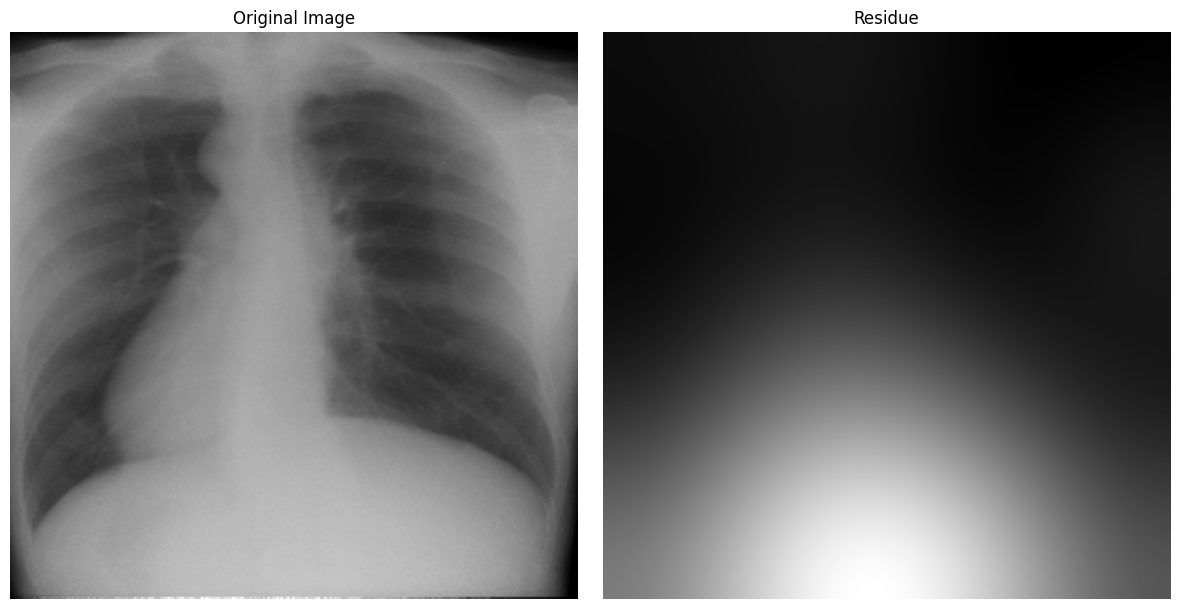

True

In [ ]:
# display original image and residue
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(residue)
plt.title("Residue")
plt.axis("off")

plt.tight_layout()
plt.show()

# save the residue image
cv2.imwrite("residue.png", residue)

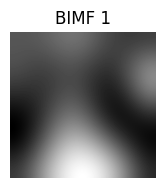

In [ ]:
# plot one bimfs
plt.subplot(2, 3, 2)
plt.imshow(BIMFs[4900])
plt.title(f"BIMF 1")
plt.axis("off")
plt.show()

# HMF

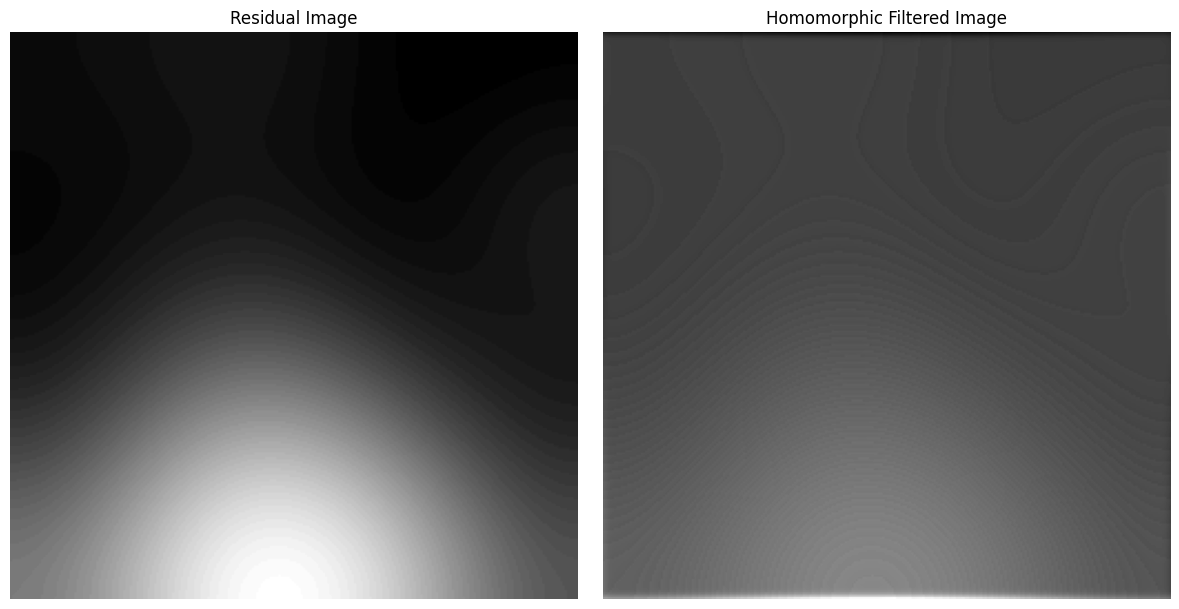

True

In [ ]:
import cv2
import numpy as np


def homomorphic_filter(image, d0=30, rh=2.0, rl=0.5, c=1.0):
    # Convert image to float32
    image = np.float32(image)
    rows, cols = image.shape

    # Apply logarithmic transform
    log_image = np.log1p(image)

    # Perform Fourier transform
    dft = cv2.dft(log_image, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Create high-frequency emphasis filter (HEF)
    u = np.arange(rows)
    v = np.arange(cols)
    u, v = np.meshgrid(u - rows / 2, v - cols / 2)
    d = np.sqrt(u**2 + v**2)
    h = (rh - rl) * (1 - np.exp(-c * (d**2 / d0**2))) + rl

    # Apply filter
    h = np.repeat(h[:, :, np.newaxis], 2, axis=2)
    dft_shift_filtered = dft_shift * h

    # Perform inverse Fourier transform
    dft_shift_filtered = np.fft.ifftshift(dft_shift_filtered)
    idft = cv2.idft(dft_shift_filtered)
    idft = cv2.magnitude(idft[:, :, 0], idft[:, :, 1])

    # Normalize the idft result to avoid overflow in expm1
    idft = cv2.normalize(idft, None, 0, 1, cv2.NORM_MINMAX)

    # Apply exponential transform
    exp_image = np.expm1(idft)

    # Handle NaN and Inf values
    exp_image = np.nan_to_num(exp_image, nan=0.0, posinf=255.0, neginf=0.0)

    # Normalize the image to 0-255
    exp_image = cv2.normalize(exp_image, None, 0, 255, cv2.NORM_MINMAX)
    exp_image = np.uint8(exp_image)

    return exp_image


# Load the residual image
residual_image = cv2.imread("residue.png", cv2.IMREAD_GRAYSCALE)

# Load the residue image
# residual_image = residue

# Apply homomorphic filter with HEF
filtered_image = homomorphic_filter(residual_image)

# Display the results using plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(residual_image)
plt.title("Residual Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(filtered_image)
plt.title("Homomorphic Filtered Image")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save the filtered image
cv2.imwrite("filtered_image.png", filtered_image)

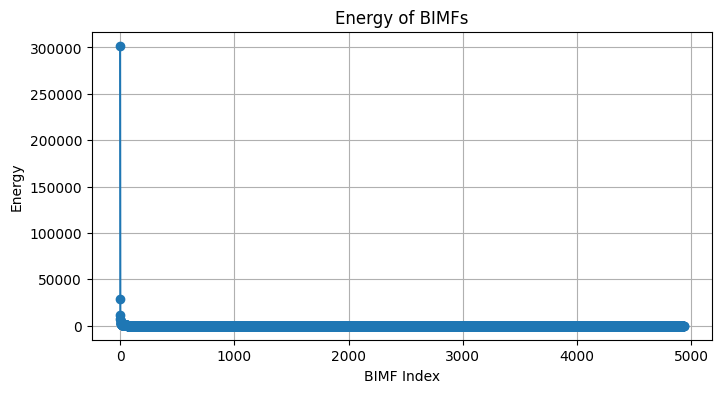

In [29]:
import numpy as np


def calculate_bimf_energy(bimfs):
    """
    Calculate the energy of each BIMF.

    Parameters:
    bimfs (list of np.ndarray): List of BIMF components.

    Returns:
    list of float: Energies of each BIMF.
    """
    energies = []
    for bimf in bimfs:
        energy = np.sum(np.square(bimf))
        energies.append(energy)
    return energies


# Contoh penggunaan
# Misalkan kita memiliki daftar BIMF yang telah diekstraksi dari gambar
# bimfs = [bimf1, bimf2, bimf3]  # Gantilah dengan BIMF yang sebenarnya

# Hitung energi dari setiap BIMF
energies = calculate_bimf_energy(BIMFs)

# Tampilkan energi dari setiap BIMF
# for i, energy in enumerate(energies):
#     print(f"Energy of BIMF {i+1}: {energy}")

# Plot the energy of each BIMF
plt.figure(figsize=(8, 4))
plt.plot(energies, marker="o")
plt.xlabel("BIMF Index")
plt.ylabel("Energy")
plt.title("Energy of BIMFs")
plt.grid(True)
plt.show()

# NonLinear Filtering

True

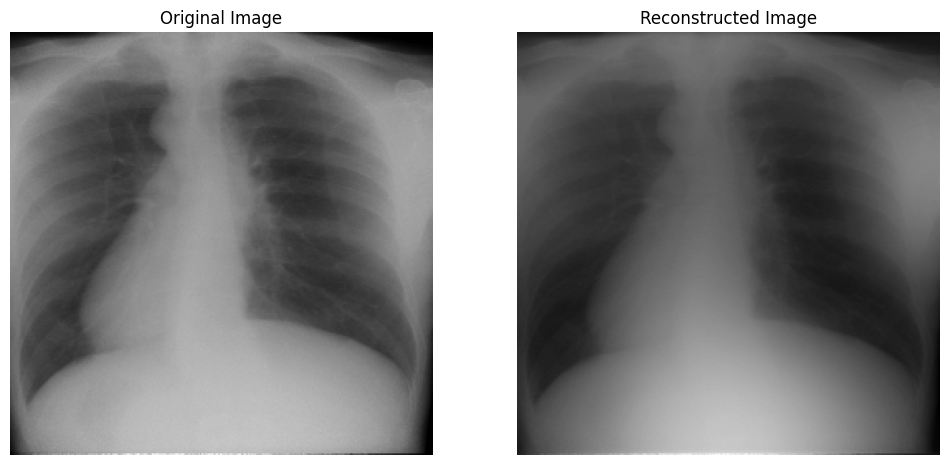

In [ ]:
def nl_means_filtering(bimf, h=10, templateWindowSize=7, searchWindowSize=21):
    # Check if BIMF is already in 8-bit unsigned integer format
    if bimf.dtype != np.uint8:
        # Convert BIMF to 8-bit unsigned integer
        bimf = cv2.normalize(bimf, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # Apply NL-means filter
    return cv2.fastNlMeansDenoising(bimf, None, h, templateWindowSize, searchWindowSize)


def reconstruct_image(bimfs, energies, R, beta, filtered_residual):
    # Sort BIMFs based on energy
    sorted_indices = np.argsort(energies)

    # Denoise R components with the lowest energy
    denoised_bimfs = []
    for i in range(R):
        index = sorted_indices[i]
        denoised_bimfs.append(nl_means_filtering(bimfs[index]))

    # Combine denoised BIMFs and original BIMFs
    I_E = np.sum(denoised_bimfs, axis=0).astype(np.float64)
    for j in range(R, len(bimfs)):
        index = sorted_indices[j]
        I_E += bimfs[index].astype(np.float64)

    # Reconstruct the image by adding the filtered residual
    I_L = I_E + beta * filtered_residual.astype(np.float64)
    return I_L


# Tentukan jumlah komponen energi terendah yang akan didenoise
R = 1  # Misalkan kita memilih 1 komponen energi terendah

# Tentukan parameter beta
beta = 0.5  # Misalkan kita memilih nilai beta 0.5

# Rekonstruksi gambar
reconstructed_image = reconstruct_image(BIMFs, energies, R, beta, filtered_image)

# Tampilkan gambar hasil rekonstruksi and compare with the original image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis("off")


# Save the reconstructed image
cv2.imwrite("reconstructed_image.png", reconstructed_image)

# Gamma correction

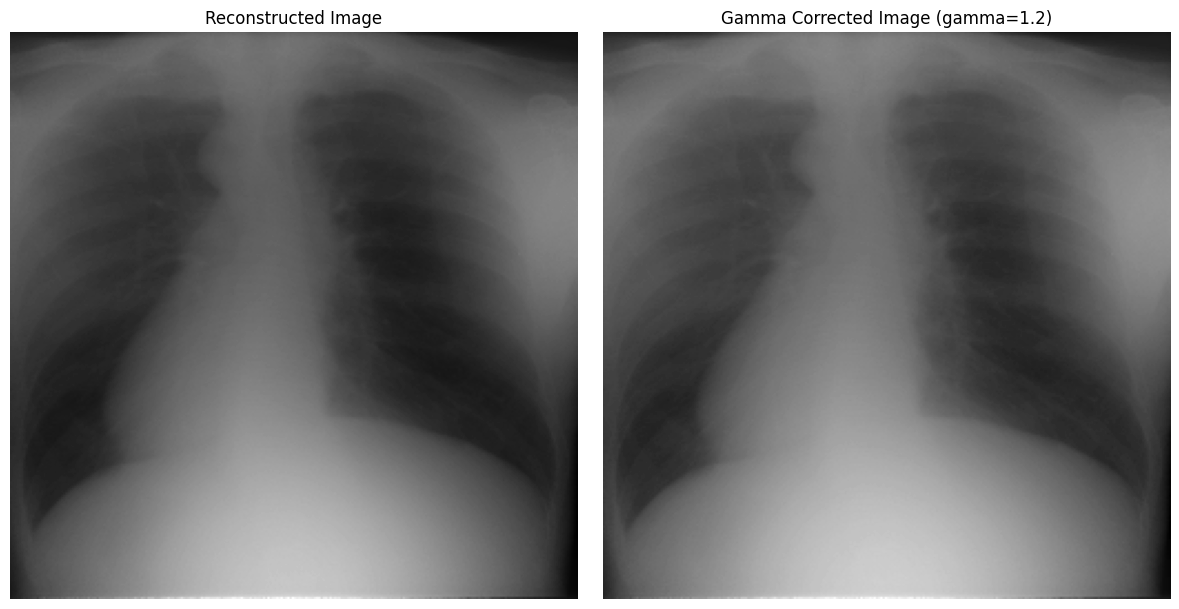

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def gamma_correction(image, gamma):
    # Build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    inv_gamma = 1.0 / gamma
    table = np.array(
        [((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]
    ).astype("uint8")

    # Ensure the image is in 8-bit format
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply gamma correction using the lookup table
    return cv2.LUT(image, table)


# Example usage
# Assume we have the reconstructed image
# reconstructed_image = cv2.imread("reconstructed_image.png", cv2.IMREAD_GRAYSCALE)

# Apply gamma correction with gamma value 1.2
gamma = 1.2  # Example gamma value
gamma_corrected_image = gamma_correction(reconstructed_image, gamma)

# Display the gamma corrected image and compare with reconstructed image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(gamma_corrected_image)
plt.title(f"Gamma Corrected Image (gamma={gamma})")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save the gamma corrected image
cv2.imwrite("gamma_corrected_image.png", gamma_corrected_image)

# CLAHE

In [ ]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # Apply CLAHE to the image
    return clahe.apply(image)

clahe_image = apply_clahe(gamma_corrected_image)

# Display the CLAHE image and compare with the gamma corrected image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gamma_corrected_image)
plt.title("Gamma Corrected Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(clahe_image)
plt.title("CLAHE Image")
plt.axis("off")

plt.tight_layout()
plt.show()